* Testing Image processing in Python using Jupyter Notebooks
Load all libraries

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyshearlab import SLgetShearletSystem2D, SLsheardec2D, SLnormalizeCoefficients2D, modulate2, dfilters
from scipy.signal import hilbert
from skimage.morphology import skeletonize, binary_closing, thin, diamond, footprint_rectangle
from skimage.transform import resize
import scipy.ndimage as ndi
from bm3d import bm3d, BM3DProfile

512


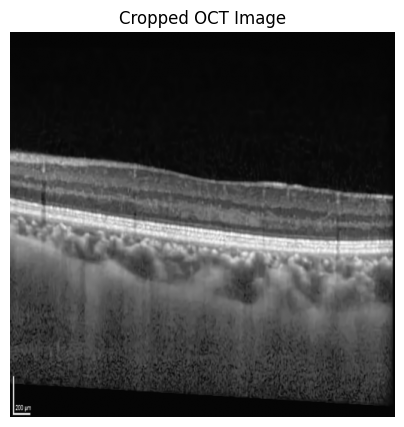

In [219]:

# filePath = 'Data/Cirrus/OrgImg_0020.jpg'
filePath = 'Data/Heidelberg/LeeS OS020.bmp'
# filePath = 'Data/PlexElite/img_0001.jpg'
image = Image.open(filePath).convert('L')

if filePath.__contains__('Heidelberg'):
    left, top, right, bottom = 1540, 500, 2304, 1010  # example values
    image = image.crop((left, top, right, bottom))

# Resize Image to 512x512
qLen = 512
resized_img = image.resize((qLen, qLen))
data = np.asarray(resized_img, dtype=np.float32) / 255.0
nx, ny = data.shape
print(nx)

#optional Filtering
data = ndi.median_filter(data, size=(1, 3))

#  Denoise the heck out of that
# bm3d_sigma = 0.1 # Only for PlexElite
bm3d_sigma = 0.05 # Only for Heidelberg
# bm3d_sigma = 0.08 # For Cirrus

# Normalize to [0, 1] safely
img_min, img_max = np.min(image), np.max(image)
normalized = (image - img_min) / (img_max - img_min)
denoised = bm3d(normalized, bm3d_sigma, profile=BM3DProfile())
denoised_resized = resize(denoised, (qLen, qLen), preserve_range=True, anti_aliasing=True)

plt.figure(figsize=(5, 5))
plt.imshow(denoised_resized, cmap='gray')
plt.title("Cropped OCT Image")
plt.axis('off')
plt.show()

In [220]:
# Parameters for shearlet decomposition
nScales = 2
shearLevels = np.array([1, 2])


# Extract the appropriate filter from the tuple returned by dfilters
filter_tuple = dfilters('cd', 'd')
directionalFilter = modulate2(filter_tuple[0], 'r')


# Get the complete shearlet system
# shearletSystem = SLgetShearletSystem2D(1, nx, ny, nScales,
                    # shearLevels,0,directionalFilter)
shearletSystem = SLgetShearletSystem2D(1, nx, ny, nScales,
                    shearLevels)

# Compute shearlet coefficients
# coeffs = SLsheardec2D(data, shearletSystem)
coeffs = SLsheardec2D(denoised_resized, shearletSystem)

# Normalize coefficients
coeffs_normalized = SLnormalizeCoefficients2D(coeffs, 
                   {'RMS': shearletSystem["RMS"], 
                    'nShearlets': shearletSystem["shearlets"].shape[2]})

# --- Step 1: Separate even (real) and odd (imaginary) components.
if not np.iscomplexobj(coeffs_normalized):
    print("Coefficients are real; computing an imaginary part via Hilbert transform.")
    imaginary_coeffs = np.empty_like(coeffs_normalized)
    for i in range(coeffs_normalized.shape[2]):
        # Apply the Hilbert transform along rows (axis=0); you might try axis=1 if more appropriate.
        analytic_signal = hilbert(coeffs_normalized[:, :, i], axis=0)
        imaginary_coeffs[:, :, i] = np.imag(analytic_signal)
    even_coeffs = coeffs_normalized.copy()  # even-symmetric (real)
    odd_coeffs  = imaginary_coeffs.copy()      # odd-symmetric (computed imaginary part)
else:
    even_coeffs = np.real(coeffs_normalized)
    odd_coeffs  = np.imag(coeffs_normalized)



Coefficients are real; computing an imaginary part via Hilbert transform.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020821017318692483..1.0155973032440007].


Reconstructing using scales: [1, 2]


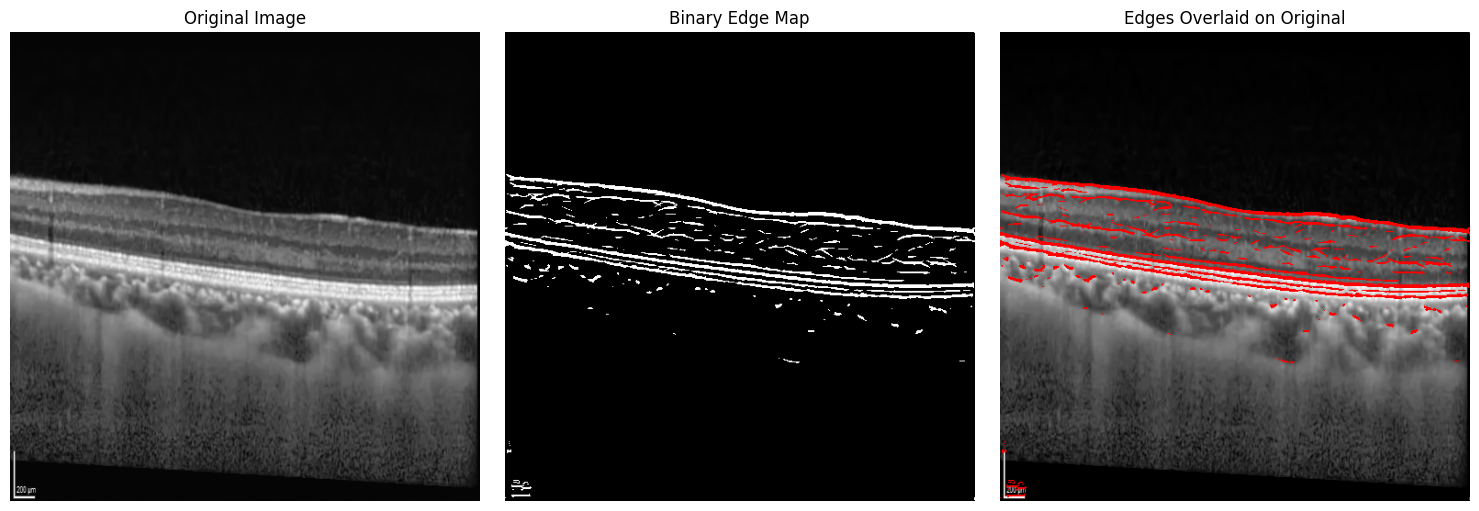

In [233]:
# for j in range(nScales):
# Parameters
nOrient = int(coeffs_normalized.shape[2] / nScales)
nx, ny, _ = coeffs_normalized.shape
# Only use these specific scales
# reconScales = [1, 2]  # Only for PlexElite
reconScales = [1, 2]  # Only for Heidelberg
# reconScales = [1, 2]  # Only for Cirrus

# reconScales = range(nScales)  # Only use these specific scales
print(f"Reconstructing using scales: {reconScales}")

# Initialize with zeros instead of uninitialized memory
preferred_odd = np.zeros((nx, ny, len(reconScales)))
preferred_even = np.zeros((nx, ny, len(reconScales)))

# Loop only over selected scales
for k, j in enumerate(reconScales):
    start = j * nOrient
    end = (j + 1) * nOrient
    
    # Extract scale-specific coefficient slices
    odd_j = odd_coeffs[:, :, start:end]
    even_j = even_coeffs[:, :, start:end]

    # Find orientation with strongest odd response
    idx = np.argmax(np.abs(odd_j), axis=2)

    I = np.arange(nx)[:, None]
    J = np.arange(ny)[None, :]
    preferred_odd[:, :, k] = odd_j[I, J, idx]
    preferred_even[:, :, k] = even_j[I, J, idx]

# Sum and max across only the used recon scales
sum_odd = np.sum(preferred_odd, axis=2)
sum_even = np.sum(preferred_even, axis=2)
max_odd = np.max(preferred_odd, axis=2)

# Noise compensation factor and epsilon (tune these experimentally)
T = 1e50
# epsilon = 0.3 # For Cirrus
epsilon = 0.15 # For Heidelberg
# epsilon = 0.2 # For PlexElite

# Number of scales is (Jmax - Jmin + 1); here it is nScales.
num_scales = nScales

# Compute the full edge measure (Equation (13))
edge_measure = (sum_odd - sum_even - (num_scales * T)) / (num_scales * max_odd + epsilon)
# Ensure the measure is non-negative (Equation (14))
edge_measure = np.clip(edge_measure, 0, 1)

# --- Step 4: (Optional) Threshold the edge measure to obtain a binary edge map.
threshold = 0.6  # Adjust as needed
binary_edges = edge_measure > threshold

# Convert the original grayscale image "data" (values in [0,1]) to RGB.
rgb_image = np.stack((denoised_resized, denoised_resized, denoised_resized), axis=-1)
overlay_image = rgb_image.copy()
overlay_image[binary_edges] = [1, 0, 0]  # set edge pixels to red

# --- Step 6: Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(denoised_resized, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(binary_edges, cmap='gray')
axes[1].set_title('Binary Edge Map')
axes[1].axis('off')

axes[2].imshow(overlay_image)
axes[2].set_title('Edges Overlaid on Original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

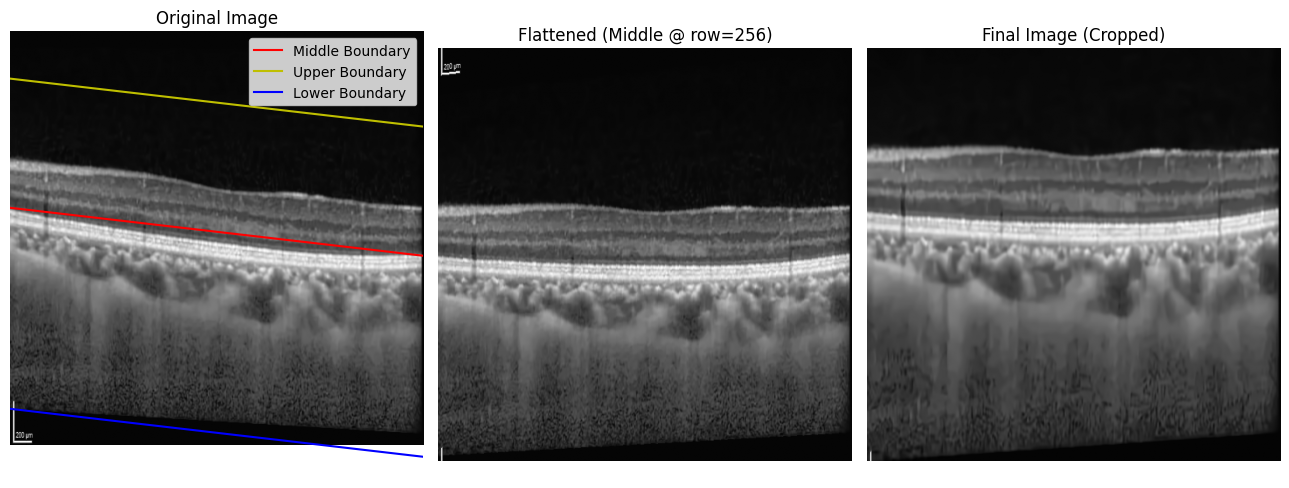

In [235]:
# --- Config: choose between 'pad' or 'crop' ---
# flatten_mode = 'pad'  # or 'crop'
flatten_mode = 'crop'  # or 'pad'

# --- Step 1: Estimate boundaries from edge map ---
nx, ny = binary_edges.shape
x_coords, y_coords = [], []
y_min_coords, y_max_coords = [], []

for x in range(ny):
    edge_rows = np.where(binary_edges[:, x])[0]
    if edge_rows.size > 0:
        y_coords.append(edge_rows[len(edge_rows) // 2])
        y_min_coords.append(edge_rows[0])
        y_max_coords.append(edge_rows[-1])
        x_coords.append(x)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
y_min_coords = np.array(y_min_coords)
y_max_coords = np.array(y_max_coords)

x_full = np.arange(ny)
y_coords_full = np.interp(x_full, x_coords, y_coords)
y_min_full = np.interp(x_full, x_coords, y_min_coords)
y_max_full = np.interp(x_full, x_coords, y_max_coords)

# --- Step 2: Polynomial fit + shift calculation ---
# poly_deg = 4 # For PlexElite
poly_deg = 1 # For Heidelberg
# poly_deg = 4 # For Cirrus
polyCoeffs = np.polyfit(x_full, y_coords_full, deg=poly_deg)
reference_row = nx // 2

flattened = np.zeros_like(denoised_resized)
flattened_edges = np.zeros_like(binary_edges)

for x in range(ny):
    y_boundary = int(round(np.polyval(polyCoeffs, x)))
    shift = reference_row - y_boundary
    flattened[:, x] = np.roll(denoised_resized[:, x], shift)
    flattened_edges[:, x] = np.roll(binary_edges[:, x], shift)

# --- Step 3: Define boundaries ---
dx_min = y_min_full - y_coords_full
dx_max = y_max_full - y_coords_full

padding_top = 100 # Only for PlexElite
# padding_top = -100 # Only for Cirrus
padding_bot = 200 # Only for PlexElite
# padding_bot = -80 # Only for Cirrus

avg_dx_min = int(np.mean(dx_min))
avg_dx_max = int(np.mean(dx_max))

cut_top = reference_row + avg_dx_min - padding_top
cut_bottom = reference_row + avg_dx_max + padding_bot

# --- Step 4: Apply mode-dependent preprocessing ---
if flatten_mode == 'pad':
    # Apply padding (preferred for frequency preservation)
    cut_image = flattened[max(cut_top, 0):min(cut_bottom, nx), :]
    target_height = nx
    current_height = cut_image.shape[0]
    pad_total = max(0, target_height - current_height)
    pad_top = pad_total // 2
    pad_bottom = pad_total - pad_top

    final_image = np.pad(cut_image, ((pad_top, pad_bottom), (0, 0)),
                         mode='constant', constant_values=0)

elif flatten_mode == 'crop':
    # Apply hard cropping and resize back
    cut_image = flattened[max(cut_top, 0):min(cut_bottom, nx), :]
    final_image = resize(cut_image, (nx, ny), order=1,
                         preserve_range=True, anti_aliasing=True)
else:
    raise ValueError(f"Unknown flatten_mode: {flatten_mode}. Use 'pad' or 'crop'.")

# --- Step 4.5: Filtering ---
# sigma = 0.05; # For PlexElite
# sigma = 0.0000000005; # For Heidelberg
sigma = 0.05; # For Cirrus

final_image_filt = bm3d(final_image, sigma, profile=BM3DProfile())

# --- Step 5: Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

# Show fitted polynomial + bounds
axes[0].imshow(denoised_resized, cmap='gray')
axes[0].plot(x_full, np.polyval(polyCoeffs, x_full), 'r-', label='Middle Boundary')
axes[0].plot(x_full, np.polyval(polyCoeffs, x_full) + avg_dx_min - padding_top, 'y-', label='Upper Boundary')
axes[0].plot(x_full, np.polyval(polyCoeffs, x_full) + avg_dx_max + padding_bot, 'b-', label='Lower Boundary')
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[0].legend()

axes[1].imshow(flattened, cmap='gray')
axes[1].set_title(f'Flattened (Middle @ row={reference_row})')
axes[1].axis('off')

axes[2].imshow(final_image_filt, cmap='gray')
axes[2].set_title(f"Final Image ({'Padded' if flatten_mode == 'pad' else 'Cropped'})")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Filter

In [243]:
# Parameters for shearlet decomposition
nScales = 2
shearLevels = np.array([1, 2, 3])
# shearLevels = np.array([1, 2]) # Only for Cirrus


# Extract the appropriate filter from the tuple returned by dfilters
filter_tuple = dfilters('cd', 'd')
directionalFilter = modulate2(filter_tuple[0], 'r')


# Get the complete shearlet system
# shearletSystem = SLgetShearletSystem2D(1, nx, ny, nScales,
                    # shearLevels,0,directionalFilter)
shearletSystem = SLgetShearletSystem2D(1, nx, ny, nScales,
                    shearLevels)

# Compute shearlet coefficients
# coeffs = SLsheardec2D(data, shearletSystem)
coeffs = SLsheardec2D(final_image_filt, shearletSystem)

# Normalize coefficients
coeffs_normalized = SLnormalizeCoefficients2D(coeffs, 
                   {'RMS': shearletSystem["RMS"], 
                    'nShearlets': shearletSystem["shearlets"].shape[2]})

# --- Step 1: Separate even (real) and odd (imaginary) components.
if not np.iscomplexobj(coeffs_normalized):
    print("Coefficients are real; computing an imaginary part via Hilbert transform.")
    imaginary_coeffs = np.empty_like(coeffs_normalized)
    for i in range(coeffs_normalized.shape[2]):
        # Apply the Hilbert transform along rows (axis=0); you might try axis=1 if more appropriate.
        analytic_signal = hilbert(coeffs_normalized[:, :, i], axis=0)
        imaginary_coeffs[:, :, i] = np.imag(analytic_signal)
    even_coeffs = coeffs_normalized.copy()  # even-symmetric (real)
    odd_coeffs  = imaginary_coeffs.copy()      # odd-symmetric (computed imaginary part)
else:
    even_coeffs = np.real(coeffs_normalized)
    odd_coeffs  = np.imag(coeffs_normalized)





Coefficients are real; computing an imaginary part via Hilbert transform.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012851309031248093..1.005299687385559].


Reconstructing using scales: [1, 2]


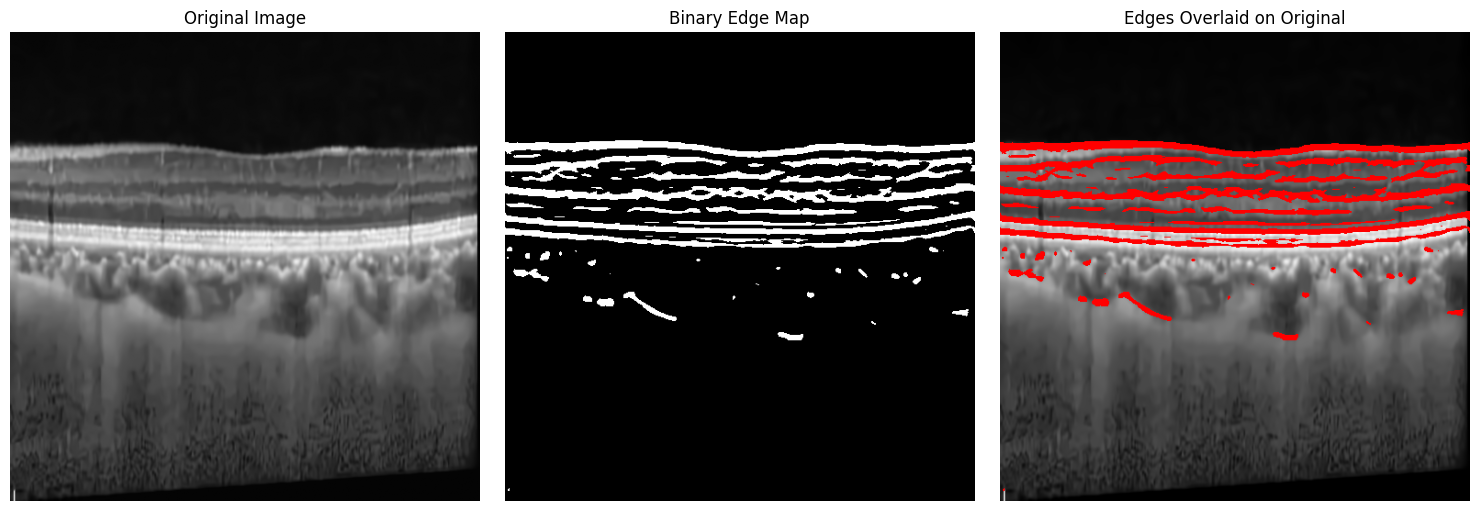

In [245]:
# Parameters
nOrient = int(coeffs_normalized.shape[2] / nScales)
nx, ny, _ = coeffs_normalized.shape
# Only use these specific scales
# reconScales = [1, 2]  # Only for PlexElite
reconScales = [1, 2]  # Only for Heidelberg
# reconScales = [1, 2]  # Only for Cirrus

# reconScales = range(nScales)  # Only use these specific scales
print(f"Reconstructing using scales: {reconScales}")

# Initialize with zeros instead of uninitialized memory
preferred_odd = np.zeros((nx, ny, len(reconScales)))
preferred_even = np.zeros((nx, ny, len(reconScales)))

# Loop only over selected scales
for k, j in enumerate(reconScales):
    start = j * nOrient
    end = (j + 1) * nOrient
    
    # Extract scale-specific coefficient slices
    odd_j = odd_coeffs[:, :, start:end]
    even_j = even_coeffs[:, :, start:end]

    # Find orientation with strongest odd response
    idx = np.argmax(np.abs(odd_j), axis=2)

    I = np.arange(nx)[:, None]
    J = np.arange(ny)[None, :]
    preferred_odd[:, :, k] = odd_j[I, J, idx]
    preferred_even[:, :, k] = even_j[I, J, idx]

# Sum and max across only the used recon scales
sum_odd = np.sum(preferred_odd, axis=2)
sum_even = np.sum(preferred_even, axis=2)
max_odd = np.max(preferred_odd, axis=2)

# Noise compensation factor and epsilon (tune these experimentally)
T = 1e50
# T = 1e-1
# epsilon = 0.05 # For Cirrus
epsilon = 0.2 # For Heidelberg
# epsilon = 0.035 # For PlexElite

# Number of scales is (Jmax - Jmin + 1); here it is nScales.
num_scales = nScales

# Compute the full edge measure (Equation (13))
edge_measure = (sum_odd - sum_even - (num_scales * T)) / (num_scales * max_odd + epsilon)
# Ensure the measure is non-negative (Equation (14))
edge_measure = np.clip(edge_measure, 0, 1)

# --- Step 4: (Optional) Threshold the edge measure to obtain a binary edge map.
threshold = 0.01  # Adjust as needed
binary_edges = edge_measure > threshold

# Convert the original grayscale image "data" (values in [0,1]) to RGB.
rgb_image = np.stack((final_image_filt, final_image_filt, final_image_filt), axis=-1)
overlay_image = rgb_image.copy()
overlay_image[binary_edges] = [1, 0, 0]  # set edge pixels to red

# --- Step 6: Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(final_image_filt, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(binary_edges, cmap='gray')
axes[1].set_title('Binary Edge Map')
axes[1].axis('off')

axes[2].imshow(overlay_image)
axes[2].set_title('Edges Overlaid on Original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01747116632759571..1.005299687385559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01747116632759571..1.005299687385559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01747116632759571..1.005299687385559].


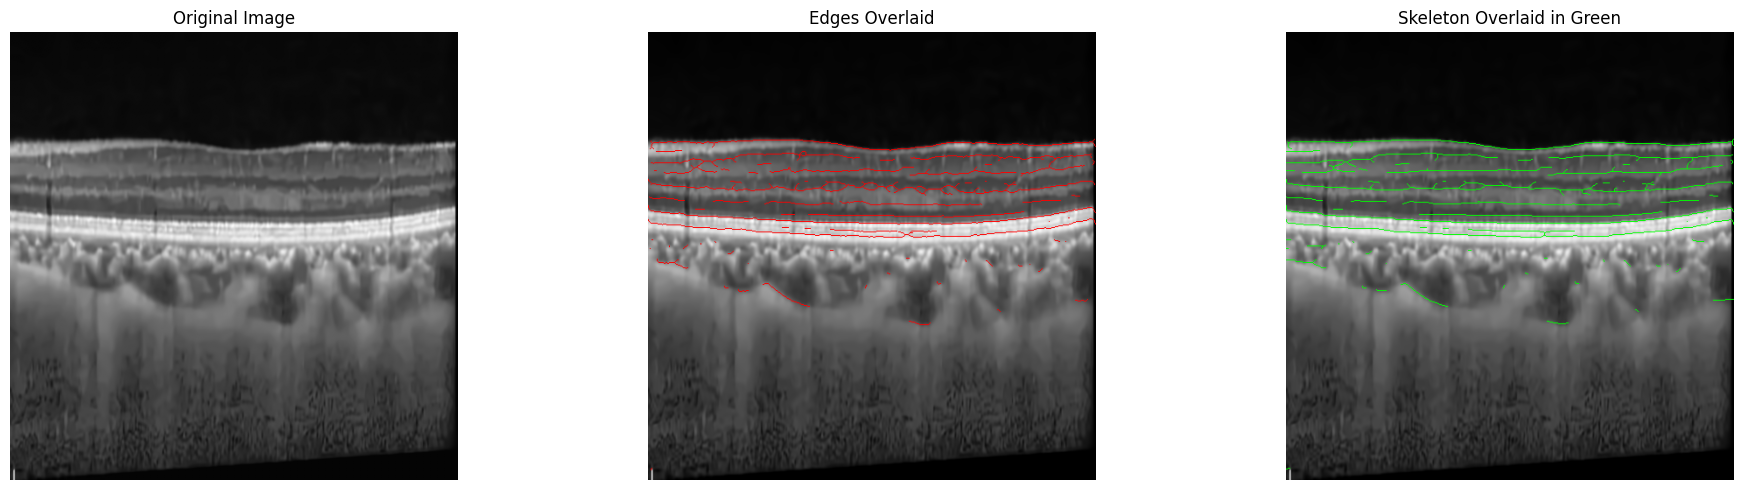

In [250]:
# --- Smarter footprint config ---
footprint_shape = (5, 50)
# footprint = np.zeros(footprint_shape, dtype=bool)

# rr, cc = ellipse(
#     r=footprint_shape[0] // 2,
#     c=footprint_shape[1] // 2,
#     r_radius=1.5,
#     c_radius=20,
#     shape=footprint_shape
# )

# footprint[rr, cc] = True

# footprint = diamond(3.5)
# footprint = footprint_rectangle((4, 20)) # Only for PlexElite
footprint = footprint_rectangle((1, 20)) # Only for HeidelBerg
# footprint = footprint_rectangle((3, 30)) # Only for Cirrus

# plt.figure(figsize=(5, 5))
# plt.imshow(footprint, cmap='gray')
# plt.title("Binary Closing Footprint")
# plt.axis('off')
# plt.show()

# --- Edge postprocessing ---
thinned = thin(binary_edges)
for i in range(3):  # 5 might be overkill; 2–3 is usually enough
    thinned = thin(thinned)

closed_edges = binary_closing(thinned, footprint=footprint)
skeleton = skeletonize(closed_edges)
# Get flattened overlay image
rgb_image = np.dstack([final_image_filt, final_image_filt, final_image_filt])
overlay_image = rgb_image.copy()
overlay_image[thinned] = [1, 0, 0]  # set edge pixels to red

# Convert original grayscale to RGB
rgb_image_skel = np.dstack([final_image_filt, final_image_filt, final_image_filt])

# Color skeleton pixels in green
rgb_image_skel[skeleton] = [0, 1, 0]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(final_image_filt, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(overlay_image)
axes[1].set_title('Edges Overlaid')
axes[1].axis('off')

axes[1].imshow(overlay_image)
axes[1].set_title('Edges Overlaid')
axes[1].axis('off')

axes[2].imshow(rgb_image_skel)
axes[2].set_title("Skeleton Overlaid in Green")
axes[2].axis('off')

plt.tight_layout()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020821017318692483..1.0155973032440007].


Reversing cropping from flattening...
Skeleton is already full size. Adjusting reference row for resized coordinates...


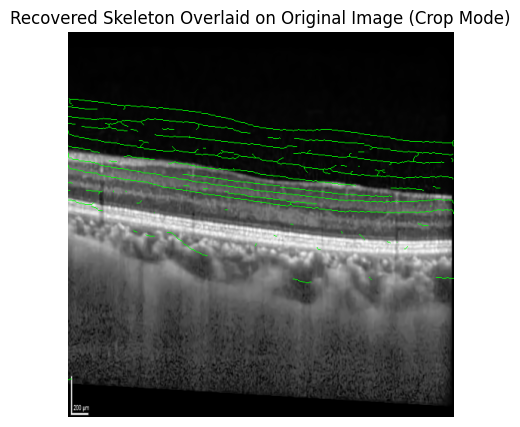

In [251]:
# --- Step 0: Prepare flattened skeleton based on flatten_mode ---
if flatten_mode == 'crop':
    print("Reversing cropping from flattening...")

    if skeleton.shape == (nx, ny):
        print("Skeleton is already full size. Adjusting reference row for resized coordinates...")
        # This is the key fix:
        crop_height = cut_bottom + cut_top - 90
        scale_factor = crop_height / nx
        effective_reference_row = int(reference_row * scale_factor)
        
        skeleton_unrolled = skeleton.copy()
    else:
        print("Skeleton is still cropped. Inserting into full-size container...")
        skeleton_unrolled = np.zeros((nx, ny), dtype=bool)
        skeleton_unrolled[cut_top:cut_bottom, :] = skeleton
        effective_reference_row = reference_row

elif flatten_mode == 'pad':
    print("Reversing padding from flattening...")
    if pad_bottom > 0:
        skeleton_unrolled = skeleton[pad_top:-pad_bottom, :]
    else:
        skeleton_unrolled = skeleton[pad_top:, :]
    effective_reference_row = reference_row
# --- Step 1: Reverse polynomial flattening ---
recovered_skeleton = np.zeros((nx, ny))
for x in range(ny):
    y_boundary = int(round(np.polyval(polyCoeffs, x)))
    shift = effective_reference_row - y_boundary
    recovered_skeleton[:, x] = np.roll(skeleton_unrolled[:, x], -shift)

# --- Step 2: Overlay recovered skeleton on original image ---
rgb_orig = np.dstack([denoised_resized]*3)
overlay_unflat = rgb_orig.copy()
overlay_unflat[recovered_skeleton > 0.5] = [0, 1, 0]

# --- Step 3: Plot result ---
plt.figure(figsize=(10, 5))
plt.imshow(overlay_unflat)
plt.title(f"Recovered Skeleton Overlaid on Original Image ({flatten_mode.capitalize()} Mode)")
plt.axis('off')
plt.show()
